In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
datasetArray = []
visualiseDataSets = False
def create_df_from_sheet(sheet: str) -> pd.DataFrame:
    df = pd.read_excel("./all data(from manon).xlsx", sheet_name=sheet)
    df.columns = df.iloc[1]
    df = df.iloc[2:]
    if len(df.columns) > 4:
        df.drop(columns=df.columns[-2:], axis=1, inplace=True)
    df.columns = ["timestamp", "no_units", "RangeCAL_uS", "SkinResistanceCAL_kOhms"]

    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y/%m/%d %H:%M:%S.%f') # change the string formatted times to pandas datetime
 
    df['timestamp'] = df.timestamp-df.timestamp[2] # convert the time to relative from the start of the measurements

    # print(df['timestamp'])
    datasetArray.append(df)
    return df


def plot_df(df: pd.DataFrame):
    if visualiseDataSets:
        df.iloc[:, [0, 1]].plot(x='timestamp', ylim=[0,3.1],xlabel='Time', ylabel='Calibration mode', rot=45)
        df.iloc[:, [0, 2]].plot(x='timestamp', xlabel='Time', ylabel='Galvanic skin response', rot=45)
        df.iloc[:, [0, 3]].plot(x='timestamp', xlabel='Time', ylabel='Skin resistance', rot=45)
        # print("hi mom")



# Loading data
Here we load the data from the excel sheets and plot it to give a general idea of what the data looks like

In [2]:
test612_2 = create_df_from_sheet("612_2")
plot_df(test612_2)

In [3]:
# test612_3 = create_df_from_sheet("612_3")
# plot_df(test612_3)

In [4]:
# test612_4 = create_df_from_sheet("612_4")
# plot_df(test612_4)

In [5]:
## BAD DATA SET
# lots of noise and no clear correlation with the tests that occurred.
# test612_5 = create_df_from_sheet("612_5")
# plot_df(test612_5)

In [6]:
# test612_6 = create_df_from_sheet("612_6")
# plot_df(test612_6)

In [7]:
# test612_7 = create_df_from_sheet("612_7")
# plot_df(test612_7)

In [8]:
# test712_1 = create_df_from_sheet("712_1")
# plot_df(test712_1)

In [9]:
# test712_2 = create_df_from_sheet("712_2")
# plot_df(test712_2)

In [10]:
# test712_3 = create_df_from_sheet("712_3")
# plot_df(test712_3)

In [11]:
# test712_4 = create_df_from_sheet("712_4")
# plot_df(test712_4)

In [12]:
# test712_5 = create_df_from_sheet("712_5")
# plot_df(test712_5)

In [13]:
# test712_6 = create_df_from_sheet("712_6")
# plot_df(test712_6)

In [14]:
# test712_7 = create_df_from_sheet("712_7")
# plot_df(test712_7)

In [15]:
# test712_8 = create_df_from_sheet("712_8")
# plot_df(test712_8)

# random starts here
Run cells below again with "random_dataset = True" to get a random dataset which was loaded in with the "create_df_from_sheet" function. If not set to true, it is possible to manually change the dataset.

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

random_dataset = False

dfTemp= datasetArray[0]
if(random_dataset):
    dfTemp =  np.random.choice(datasetArray)
    print(type(dfTemp))

dfTemp['RangeCAL_uS'] = scaler.fit_transform(dfTemp[['RangeCAL_uS']])

# df1_1 = dfTemp.iloc[:, [0, 1]] # calibration value, unused
df1_2 = dfTemp.iloc[:, [0, 2]]
# df1_3 = dfTemp.iloc[:, [0, 3]] # secondary sensor with basically the same values as the first, but with inverted values. unused.
df1_2

,timestamp,RangeCAL_uS
2,0 days 00:00:00,0.086775
3,0 days 00:00:00.250000,0.086822
4,0 days 00:00:00.500000,0.086965
5,0 days 00:00:00.750000,0.087772
6,0 days 00:00:01,0.087060
...,...,...
7286,0 days 00:30:21.694000,0.850364
7287,0 days 00:30:21.944000,0.850910
7288,0 days 00:30:22.194000,0.850910
7289,0 days 00:30:22.444000,0.854733


/tmp/ipykernel_16551/735316904.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_['RollingMean'] = dataframe_['RangeCAL_uS'].rolling(40).mean() # rolling average of 10 seconds (4 units = 1 second)


<AxesSubplot: xlabel='Time', ylabel='Scaled sensor value'>

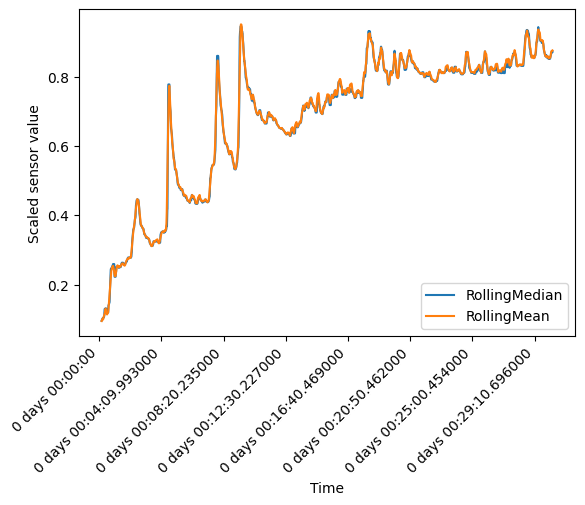

In [17]:
def calculateRollingAndDelta(dataframe_):
    # dataframe_.info()
    dataframe_['RollingMean'] = dataframe_['RangeCAL_uS'].rolling(40).mean() # rolling average of 10 seconds (4 units = 1 second)
    dataframe_['RollingMedian'] = dataframe_['RangeCAL_uS'].rolling(40).median() # rolling median of 10 seconds
    dataframe_['deltaMean'] = dataframe_.RollingMean.diff(periods =1)
    dataframe_['deltaMedian'] = dataframe_.RollingMedian.diff(periods =1)
    return dataframe_
df1_2 = calculateRollingAndDelta(df1_2)
df1_2[['RollingMedian', 'RollingMean','timestamp']].plot(x='timestamp', xlabel='Time', ylabel='Scaled sensor value', rot=45)
    

In [18]:
anomaly_detection_df = df1_2[['timestamp', 'deltaMean', 'RollingMean']].copy().dropna()
anomaly_detection_df = anomaly_detection_df.reset_index()
# anomaly_detection_df['time_index'] = anomaly_detection_df.index
anomaly_detection_df

,index,timestamp,deltaMean,RollingMean
0,42,0 days 00:00:10,0.000461,0.095228
1,43,0 days 00:00:10.250000,0.000455,0.095682
2,44,0 days 00:00:10.500000,0.000455,0.096137
3,45,0 days 00:00:10.750000,0.000430,0.096567
4,46,0 days 00:00:11,0.000446,0.097013
...,...,...,...,...
7244,7286,0 days 00:30:21.694000,-0.000041,0.874611
7245,7287,0 days 00:30:21.944000,0.000246,0.874857
7246,7288,0 days 00:30:22.194000,0.000273,0.875130
7247,7289,0 days 00:30:22.444000,0.000314,0.875444


In [19]:
# from sklearn.ensemble import IsolationForest

# IF = IsolationForest(random_state=0, contamination=0.05, n_estimators=200, max_samples=0.7)
# model_data = anomaly_detection_df[['deltaMean']]
# IF.fit(model_data)

# anomaly_detection_df['scores']=IF.decision_function(model_data)
# anomaly_detection_df['anomaly']=IF.predict(model_data)

# anomaly=anomaly_detection_df.loc[anomaly_detection_df['anomaly']==-1]
# anomaly_index=list(anomaly.index)

# print(anomaly)
# # print(anomaly_index)

# anomaly_detection_df[['anomaly', 'RollingMean','deltaMean']].plot(x='timestamp', xlabel='Time', ylabel='', rot=45)

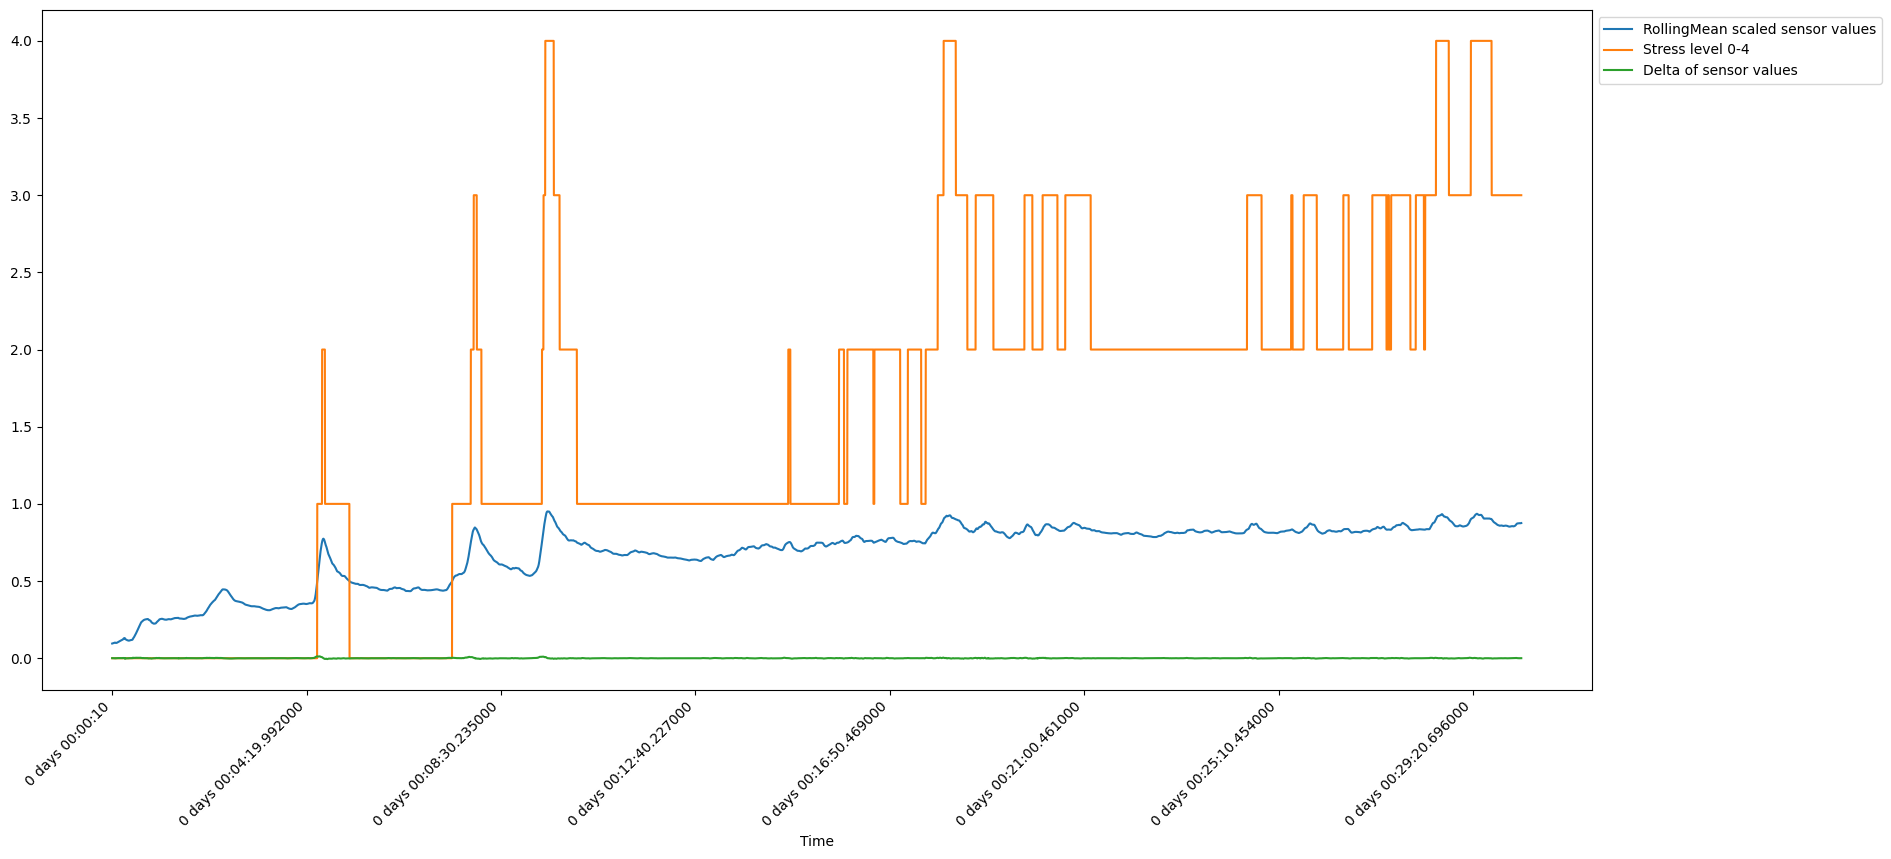

In [20]:
from sklearn.model_selection import train_test_split
stress_level = anomaly_detection_df[['RollingMean', 'deltaMean', 'timestamp']]

for index, row in stress_level.iterrows():
    if (row[0] > 0.2):
        stress_level.loc[index, 'stressLevel'] = 0
    if (row[0] > 0.4):
        stress_level.loc[index, 'stressLevel'] = 1
    if (row[0] > 0.6):
        stress_level.loc[index, 'stressLevel'] = 2
    if (row[0] > 0.8):
        stress_level.loc[index, 'stressLevel'] = 3
    if (row[0] > 0.9):
        stress_level.loc[index, 'stressLevel'] = 4


stress_level['stressLevel'] = stress_level['stressLevel'].fillna(0)
stress_level['weighted'] = (stress_level['stressLevel'] * stress_level['RollingMean']).round(0)

stress_level[['RollingMean', 'weighted', 'deltaMean', 'timestamp']].plot(x='timestamp', xlabel='Time', rot=45, figsize=[20, 10])
plt.legend(['RollingMean scaled sensor values','Stress level 0-4','Delta of sensor values'],bbox_to_anchor=(1.0, 1.0))
# stress_level[['stressed','weighted']].plot(x='timestamp', xlabel='Time', ylabel='', rot=45)
model_data = stress_level[['weighted']]
# print(stress_level)

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(
    stress_level[['RollingMean', 'deltaMean']], model_data, test_size=0.25)


In [21]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score

# comment these out to verify other datasets
tree_clf = DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_split=2)
tree_clf.fit(X_train_data,y_train_data)

# tree.plot_tree(tree_clf);
y_pred = tree_clf.predict(X_test_data)
accuracy_score(y_test_data, y_pred)

0.9613899613899614

In [22]:
# from sklearn.ensemble import RandomForestClassifier

# # comment these out to verify other datasets
# # forest_clf = RandomForestClassifier(criterion='entropy', max_depth=2, min_samples_split=2, n_estimators = 50)
# # forest_clf.fit(X_train_data,y_train_data)

# y_pred = forest_clf.predict(X_test_data)
# accuracy_score(y_test_data, y_pred)

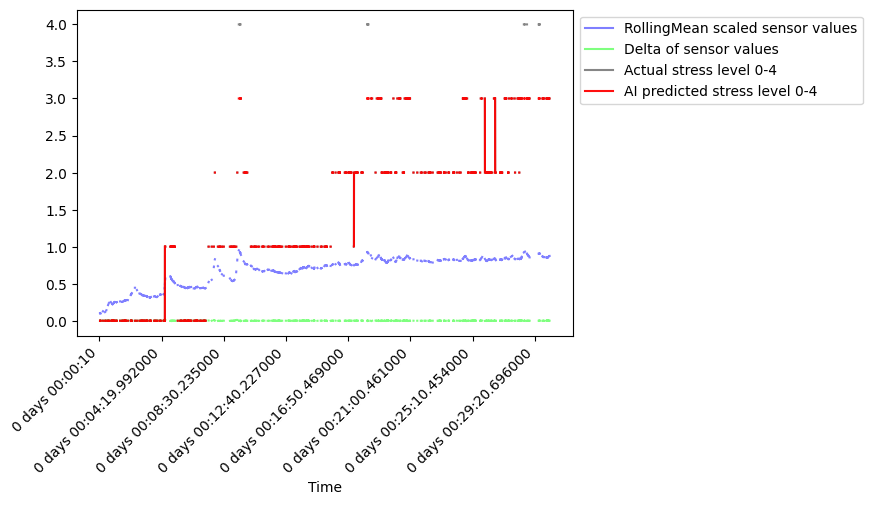

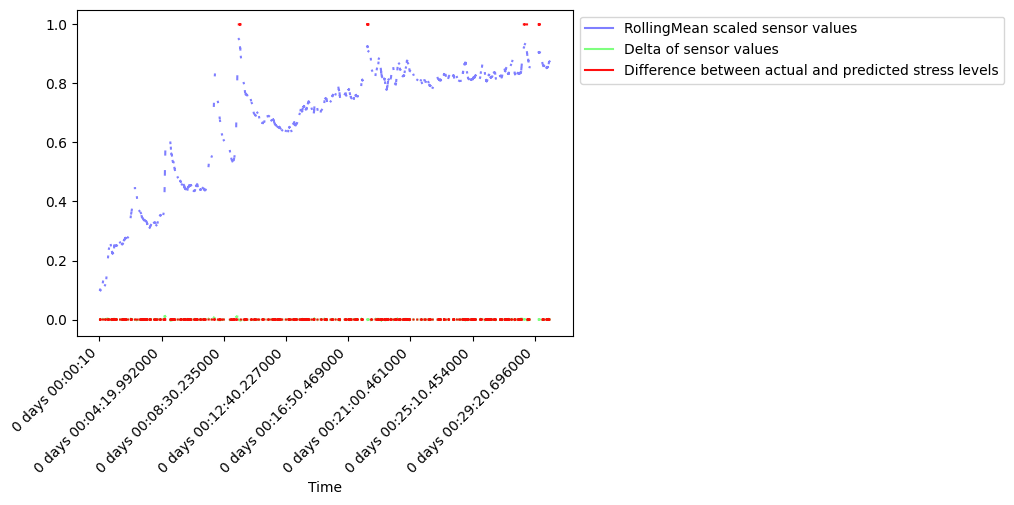

In [23]:
resultPlot = X_test_data
resultPlot['result']= y_pred
resultPlot['expected']=y_test_data

resultPlot = resultPlot.sort_index()
resultPlot_ = resultPlot
for i in resultPlot.iterrows():
    # print(i[0])
    resultPlot_.loc[i[0]]=i[1]
# resultPlot_ = resultPlot_.ffill()

# resultPlot_.reset_index()
# print(resultPlot_)x.resample('D')
resultPlot_2 = resultPlot_.sort_index().reindex(pd.RangeIndex(resultPlot_.index.max() + 1))#.ffill()
resultPlot_2['timestamp']= stress_level['timestamp']
resultPlot_2['errorMargin'] = resultPlot_2['expected']-resultPlot_2['result']
resultPlot_2[['RollingMean','deltaMean','expected', 'result', 'timestamp']].plot(x='timestamp',xlabel='Time', ylabel='', rot=45, style={'RollingMean': '#0000ff80', 'deltaMean': '#00ff0080', 'expected':'#0f0f0f80', 'result':'#ff0000f0'})#, figsize=[20,10])
plt.legend(['RollingMean scaled sensor values','Delta of sensor values','Actual stress level 0-4','AI predicted stress level 0-4'],bbox_to_anchor=(1.0, 1.0))
resultPlot_2[['RollingMean','deltaMean','errorMargin','timestamp']].plot(x='timestamp', xlabel='Time', ylabel='', rot=45, style={'RollingMean': '#0000ff80', 'deltaMean': '#00ff0080','errorMargin':'#ff0000f0'})#, figsize=[20,10])
plt.legend(['RollingMean scaled sensor values','Delta of sensor values','Difference between actual and predicted stress levels'],bbox_to_anchor=(1.0, 1.0))

# Realtime data processing using DeepHaven

In this part of the notebook we will explore the deepHaven library for realtime data processing in jupyter notebook. This is based on [this article](https://medium.com/@deephavendatalabs/real-time-tables-in-jupyter-finally-db057c2a4d3f).

In [25]:
from deephaven_server import Server
s = Server(port=8080)
s.start()

# Starting io.deephaven.python.server.EmbeddedServer
deephaven.cacheDir=/home/student/.cache/deephaven
deephaven.configDir=/home/student/.config/deephaven
deephaven.dataDir=/home/student/.local/share/deephaven
# io.deephaven.internal.log.LoggerFactoryServiceLoaderImpl: searching for 'io.deephaven.internal.log.LoggerFactory'...
# io.deephaven.internal.log.LoggerFactoryServiceLoaderImpl: found 'io.deephaven.internal.log.LoggerFactorySlf4j'
Server started on port 8080


In [26]:
from deephaven import DynamicTableWriter
import deephaven.dtypes as dht# in our example, we want to keep the text of tweet and the number of occurence of 5 keywords in this text
twitter_table_col_definitions = {"index": dht.int32, "timestamp": dht.DateTime, "RangeCAL_uS": dht.float64 ,"RollingMean": dht.float64, "deltaMean": dht.float64}
twitter_table_writer = DynamicTableWriter(twitter_table_col_definitions)
tweet_table = twitter_table_writer.table

In [27]:
import requests
import threading
from deephaven.time import now, upper_bin
from deephaven import pandas as dhpd
import time

NANOSEC_BIN = 250_000_000   # use 0.25 secs interval to get data
time_prev = 0
tweet_table = twitter_table_writer.table

print('hello world')

def get_tweets(index_):
    """
    Method to get tweets
    """
    
    value = df1_2['RangeCAL_uS'].loc[df1_2.index[index_]]
    print(value)
    df1_2.drop(index=2)
    df1_2.reset_index()
    return value

def write_live_data():
    """
    The function to write twitter data to a table
    """

    print('hello Thread')
    # df1_2['timestamp'] = pd.to_datetime(df1_2['timestamp'], format='%Y/%m/%d %H:%M:%S.%f')
    # while(2 in df1_2.index):
    for i in range(df1_2.shape[0]):
        print('in Thread')
        # print(time_prev)
        # print(now())
        time_ = now()
        timestamp = upper_bin(time_, NANOSEC_BIN) # rounding the timestamps?

        # timestamp=df1_2.loc[df1_2.index[i],'timestamp']
        RangeCAL_uS = get_tweets(i)
        # do data processing here

        # try:
        data_frame = dhpd.to_pandas(tweet_table)
        
        # print(data_frame)
        data_frame = calculateRollingAndDelta(data_frame)
        
        dataTemp = data_frame.fillna(0)
            # print(tree_clf.predict(dataTemp))
        RollingMean = dataTemp['RollingMean'].loc[dataTemp.index[i]]
        deltaMean = dataTemp['deltaMean'].loc[dataTemp.index[i]]
        twitter_table_writer.write_row(i, timestamp, RangeCAL_uS, RollingMean, deltaMean)# Run the thread that writes tweets to the table

        # if(RollingMean.any()):
        #     print(RollingMean[2])
        time.sleep(0.25) # delay to prevent crashing I hope
        global stop_threads
        if stop_threads:
            print('killed Thread')
            break
    print('goodbye Thread')

    # get the data as long as there is any
stop_threads=False
thread = threading.Thread(target=write_live_data)
thread.start()
# thread.join()
# print(len(df1_2))
# time.sleep(10)
print('goodbye world')

In [28]:

time.sleep(10)

stop_threads=True # when this is called the thread(s) made above will exit

# dataTemp = df1_2[['RollingMean', 'deltaMean']]
# print(tree_clf.predict(dataTemp))

Here we have a realtime view of the data as it comes in

In [29]:
# from deephaven_ipywidgets import DeephavenWidget
# t = DeephavenWidget(tweet_table)
# display(t)

In [30]:
from deephaven import pandas as dhpd

data_frame = dhpd.to_pandas(tweet_table)
data_frame

# display(DeephavenWidget(tweet_table, width=800, height=300))

,index,timestamp,RangeCAL_uS,RollingMean,deltaMean
0,0,2022-12-06 13:13:01.500,0.086775,0.0,0.0
1,1,2022-12-06 13:13:02.000,0.086822,0.0,0.0
2,2,2022-12-06 13:13:02.250,0.086965,0.0,0.0
3,3,2022-12-06 13:13:02.500,0.087772,0.0,0.0
4,4,2022-12-06 13:13:02.750,0.087060,0.0,0.0
5,5,2022-12-06 13:13:03.000,0.087297,0.0,0.0
6,6,2022-12-06 13:13:03.250,0.087250,0.0,0.0
7,7,2022-12-06 13:13:03.500,0.087250,0.0,0.0
8,8,2022-12-06 13:13:03.750,0.087297,0.0,0.0
9,9,2022-12-06 13:13:04.000,0.087345,0.0,0.0


In [31]:
# from deephaven import agg as agg
# from deephaven import SortDirection
# cols = []
# heat_cols = []
# for i, keyword in enumerate(KEYWORDS):
#     cols.append(f"{keyword.upper()} = KEYWORD{i+1}")
#     heat_cols.append(f"{keyword.upper()} = heatmap({keyword.upper()}, 0, 10, LEMONCHIFFON, GOLD)")
#     result = tweet_table.agg_by([agg.sum_(cols=cols)], by=["TIMESTAMP"])
# result_heat = result.format_columns(heat_cols)
# result_heat = result_heat.sort(order_by=["TIMESTAMP"], order=[SortDirection.DESCENDING])
# display(DeephavenWidget(result_heat, width=800, height=300))